In [1]:
%%html
<style>@font-face{font-family:Vazir;src:url(Vazir.eot);src:url(Vazir.eot?#iefix) format("embedded-opentype"),url(Vazir.woff2) format("woff2"),url(Vazir.woff) format("woff"),url(Vazir.ttf) format("truetype");font-weight:400;font-style:normal}.farsi{font-family:Vazir;direction:rtl}.center{text-align:center}.justify{text-align:justify}.blue{color:blue}.green{color:green}</style>

# <div class = "farsi center green">بسم الله الرحمن الرحیم</div>

## <div class = "farsi center blue">خواندن از فایل‌های ورودی</div>

In [2]:
import pandas as pd
import numpy as np

CIFAR_LENGTH  = 32

train_data    = pd.read_csv('CIFAR10/CIFAR10_train_data.csv' ,header=None)
train_label   = pd.read_csv('CIFAR10/CIFAR10_train_label.csv',header=None)
test_data     = pd.read_csv('CIFAR10/CIFAR10_val_data.csv'   ,header=None)
test_label    = pd.read_csv('CIFAR10/CIFAR10_val_label.csv'  ,header=None)

classes = list(set(train_label[0].values))

train_data['labels'] = train_label[0].apply(lambda x:classes.index(x))
test_data['labels']  = test_label[0].apply(lambda x:classes.index(x))

print('loading........done')

loading........done


## <div class = "farsi center blue">استفاده از cuda در صورت وجود</div>

In [3]:
import torch
calc_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("calc device is %s" % calc_device)

calc device is cuda


## <div class = "farsi center blue">آماده سازی داده‌ها با batch_size = 32</div>

In [4]:
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.ToTensor()

def vec_to_img(img_vec):
    img_vec = img_vec.astype(np.uint8)
    img_arr = np.asarray(img_vec).reshape((CIFAR_LENGTH,CIFAR_LENGTH,3))
    return Image.fromarray(img_arr, 'RGB')

trainset    = train_data.apply(lambda x:(transform(vec_to_img(x[:-1])),x['labels']),axis = 1)
train_bs32  = torch.utils.data.DataLoader(trainset, batch_size=32)
testset     = test_data.apply(lambda x:(transform(vec_to_img(x[:-1])),x['labels']),axis = 1)
test_bs32   = torch.utils.data.DataLoader(testset, batch_size=32)

## <div class = "farsi center blue">تعریف توابع train و test شبکه</div>

In [17]:
import time
import torch.optim as optim

def train_net(net,traindata = train_bs32,custom_optimizer = None,losses_mode = False):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) if custom_optimizer is None else custom_optimizer
    losses = []
    for epoch in range(5):
        for i, data in enumerate(traindata, 0):
            inputs, labels = data[0].to(calc_device), data[1].to(calc_device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if losses_mode:
                losses.append(loss.item())
    return losses

def test_net(net,testdata = test_bs32):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testdata:
            images, labels =  data[0].to(calc_device), data[1].to(calc_device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total
    
def train_and_test_net(net,traindata = train_bs32,testdata = test_bs32,custom_optimizer = None,losses_mode = False):
    t = time.time()
    losses = train_net(net,traindata,custom_optimizer,losses_mode)
    elapsed = time.time() - t
    if losses_mode:
        return test_net(net,testdata),elapsed,losses
    return test_net(net,testdata),elapsed

# <div class = "farsi center green">سوال ۱</div>

## <div class = "farsi center blue">تعریف شبکه سوال یک</div>

In [6]:
import torch.nn as nn
import torch.nn.functional as nnf

class NetQ1(nn.Module):
    def __init__(self,random = False):
        super(NetQ1, self).__init__()
        
        self.activation = nnf.relu
        
        self.layer1 = nn.Conv2d(3, 15, 5)
        self.layer2 = nn.Conv2d(15,250, 9)
        self.ol_size = 250 * 20 * 20
        self.outputlayer = nn.Linear(self.ol_size, 10)
        if random:    
            self.layer1.weight = torch.nn.Parameter(torch.randn(self.layer1.weight.size()))
            self.layer2.weight = torch.nn.Parameter(torch.randn(self.layer2.weight.size()))
            self.outputlayer.weight = torch.nn.Parameter(torch.randn(10,self.ol_size))
        self.to(device = calc_device)
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = x.view(-1, self.ol_size)
        x = self.outputlayer(x)
        return x

## <div class = "farsi center blue">بررسی شبکه در حالت وزن عادی و رندوم</div>

In [7]:
normal_net = NetQ1()
random_net = NetQ1(random = True)
print("Accuracy of normal_net is %d %% in %d seconds" % train_and_test_net(normal_net))
print("Accuracy of random_net is %d %% in %d seconds" % train_and_test_net(random_net))

Accuracy of normal_net is 61 % in 56 seconds
Accuracy of random_net is 9 % in 55 seconds


<div class="farsi justify">
    همانطور که مشاهده می‌شود در حالتی که وزن رندوم داده شده است دقت شبکه حدود ۱۰ درصد است که این مقدار دقت دقتی است که در حالت شانسی پاسخ دادن تولید می‌شود. که تنها راه جبران آن افزایش epoch است تا با ترین کردن زیاد تاثیر داده‌های رندوم کم شود.
</div>

# <div class = "farsi center green">سوال ۲</div>

## <div class = "farsi center blue">تعریف شبکه سوال دو</div>

In [8]:
import torch.nn as nn
import torch.nn.functional as nnf

class NetQ2(nn.Module):
    def __init__(self,random = False):
        super(NetQ2, self).__init__()
        
        self.activation = nnf.relu
        self.layer1 = nn.Conv2d(3, 15, 5)
        self.ol_size = 15*28*28
        self.outputlayer = nn.Linear(self.ol_size, 10)
        if random:    
            self.layer1.weight = torch.nn.Parameter(torch.randn(self.layer1.weight.size()))
            self.outputlayer.weight = torch.nn.Parameter(torch.randn(10,self.ol_size))
        self.to(device = calc_device)
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = x.view(-1, self.ol_size)
        x = self.outputlayer(x)
        return x

## <div class = "farsi center blue">بررسی شبکه در حالت وزن عادی و رندوم</div>

In [9]:
normal_net = NetQ2()
random_net = NetQ2(random = True)
print("Accuracy of normal_net is %d %% in %d seconds" % train_and_test_net(normal_net))
print("Accuracy of random_net is %d %% in %d seconds" % train_and_test_net(random_net))

Accuracy of normal_net is 53 % in 8 seconds
Accuracy of random_net is 9 % in 7 seconds


<div class="farsi justify">
    نتیجه مانند سوال یک است فقط چون با دو لایه است دقت آن کمتر است.
</div>

# <div class = "farsi center green">سوال ۳</div>

In [10]:
transformQ3   = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainsetQ3    = train_data.apply(lambda x:(transformQ3(vec_to_img(x[:-1])),x['labels']),axis = 1)
trainQ3_bs32  = torch.utils.data.DataLoader(trainset, batch_size=32)
testsetQ3     = test_data.apply(lambda x:(transformQ3(vec_to_img(x[:-1])),x['labels']),axis = 1)
testQ3_bs32   = torch.utils.data.DataLoader(testset, batch_size=32)

In [11]:
normal_net = NetQ1()
random_net = NetQ1(random = True)
print("Accuracy of normal_net is %d %% in %d seconds" % train_and_test_net(normal_net,traindata = trainQ3_bs32,testdata = testQ3_bs32))
print("Accuracy of random_net is %d %% in %d seconds" % train_and_test_net(random_net,traindata = trainQ3_bs32,testdata = testQ3_bs32))

Accuracy of normal_net is 63 % in 56 seconds
Accuracy of random_net is 9 % in 56 seconds


<div class="farsi justify">
    با دقت اندکی بیشتر و در زمان مشابه با سوال یک جواب رسید. علت تاثیر ندادن لیبل این است که داده‌ها باید به طور یکسان تحت تبدیل واقع شوند.
    علت افزایش اندک دقت نیز کم شدن نویز در داده است.
</div>

# <div class = "farsi center green">سوال ۴</div>

In [22]:
import matplotlib.pylab as plt

results = {}
for lr in[0.1,0.001,0.00001]:
    normal_net = NetQ1()
    optimizer = optim.SGD(normal_net.parameters(), lr=lr, momentum=0.9)
    results[lr] = train_and_test_net(normal_net,traindata = trainQ3_bs32,testdata = testQ3_bs32,custom_optimizer = optimizer,losses_mode = True)
print('done')

done


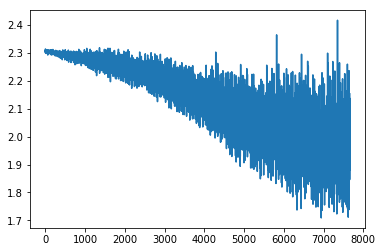

In [21]:
plt.plot(results[0.001][2])
plt.show()

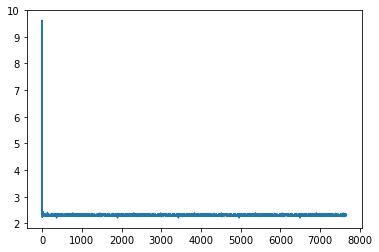

In [23]:
plt.plot(results[0.1][2])
plt.show()

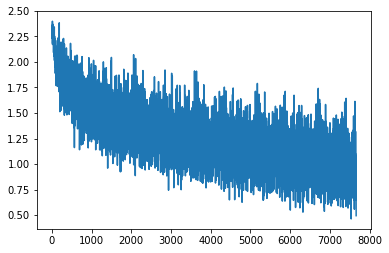

In [24]:
plt.plot(results[0.001][2])
plt.show()

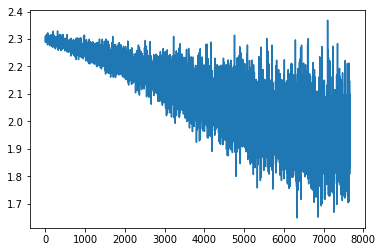

In [25]:
plt.plot(results[0.00001][2])
plt.show()

In [12]:
# relu_net       = NetQ1(activation = nnf.relu)
# leaky_relu_net = NetQ1(activation = nnf.leaky_relu)
# softplus_net   = NetQ1(activation = nnf.softplus)
# tanh_net       = NetQ1(activation = nnf.tanh)
# print("Accuracy of relu_net is %d %%" % train_and_test_net(relu_net))
# print("Accuracy of leaky_relu_net is %d %%" % train_and_test_net(leaky_relu_net))
# print("Accuracy of softplus_net is %d %%" % train_and_test_net(softplus_net))
# print("Accuracy of tanh_net is %d %%" % train_and_test_net(tanh_net))